In [1]:
# Ignore warnings for cleaner logs
import warnings
warnings.simplefilter("ignore")

In [2]:
# Installing pyloudnorm for LUFS Normalization
!pip install -q pyloudnorm

In [3]:
# Making Necessary Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyloudnorm as pyln
import librosa
from scipy.stats import skew, kurtosis

In [4]:
# Defining paths for CSVs and WAVs
csvs = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs"
wavs = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios"

In [5]:
# Reading CSVs
train_df = pd.read_csv(csvs+'/train.csv')
test_df = pd.read_csv(csvs+'/test.csv')

In [6]:
# Performing Log Transformation
y = train_df['label']
y_log = y.apply(np.log)
y.value_counts()

label
3.0    154
2.0     90
2.5     72
3.5     46
5.0     20
4.0     15
4.5     10
1.0      1
1.5      1
Name: count, dtype: int64

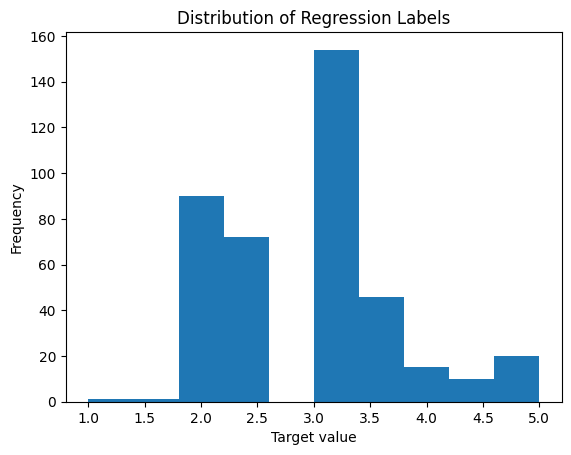

In [7]:
# Distribution of Target MOS Scores
plt.hist(y)
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.title("Distribution of Regression Labels")
plt.show()

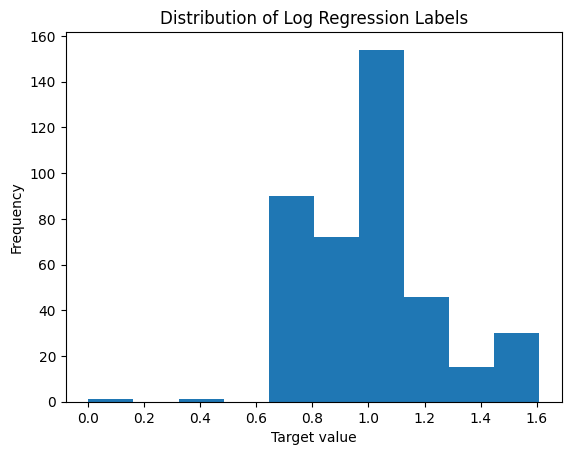

In [8]:
# Distribution of Log of Target MOS Scores
plt.hist(y_log)
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.title("Distribution of Log Regression Labels")
plt.show()

In [9]:
# Observation 1 : Log doesn't change the distribution of labels since it is a monotonic function
# Conclusion 1 : Log of Targets can be chosen as a label as well

In [10]:
# Skenwness and Kurtosis of Target MOS Scores
print("Skewness:", skew(y))
print("Kurtosis:", kurtosis(y))

Skewness: 0.9174817042602248
Kurtosis: 0.9253451781387954


In [11]:
# Skewness and Kurtosis of Log of Target MOS Scores
print("Skewness:", skew(y_log))
print("Kurtosis:", kurtosis(y_log))

Skewness: 0.12764799186291806
Kurtosis: 0.23857795156555106


In [12]:
# Observation 2: Log of Target MOS Scores show low skewness and kurtosis as compared to the raw targets
# Conclusion 2: Log of Target MOS Scores resemble the Normal Distribution better than the raw targets

In [13]:
# Laoding a sample audio for LUFS Normalization Effects
path = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_2.wav'

audio, sr = librosa.load(path, sr=16000)

meter = pyln.Meter(sr)
lufs_before = meter.integrated_loudness(audio)
audio_lufs = pyln.normalize.loudness(audio, lufs_before, -23.0)

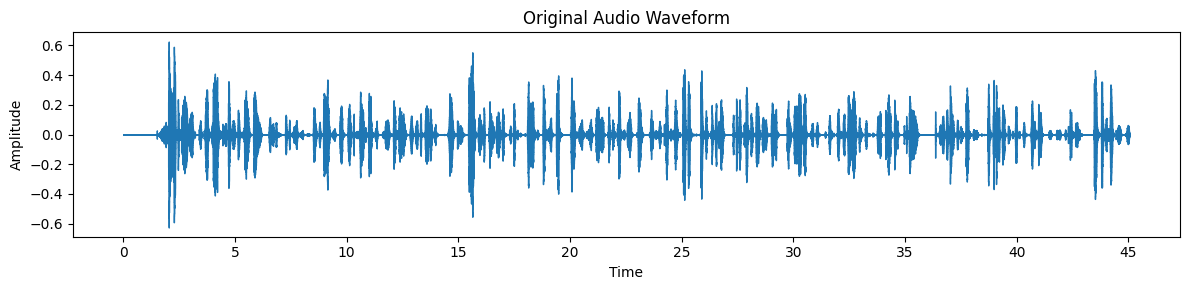

In [14]:
# Original Audio Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title("Original Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

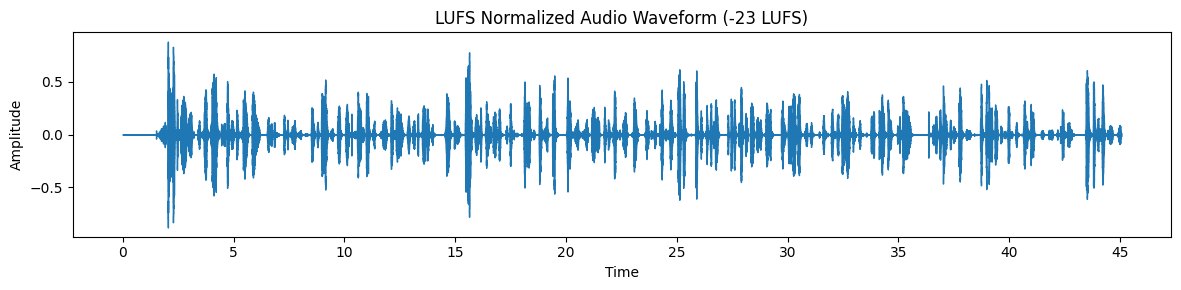

In [15]:
# LUFS Normalized Audio Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio_lufs, sr=sr)
plt.title("LUFS Normalized Audio Waveform (-23 LUFS)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [16]:
# Observation 3: LUFS Normalization doesn't inherently change the waveforms
# Conclusion 3: LUFS Normalization may be considered for pre-processing

In [17]:
# Defining short term LUFS for visualizing LUFS
def short_term_lufs(audio, sr, meter, window_sec=0.4):
    block_size = int(sr * window_sec)
    lufs_vals = []

    for i in range(0, len(audio) - block_size, block_size):
        block = audio[i:i + block_size]
        try:
            lufs_vals.append(meter.integrated_loudness(block))
        except:
            continue

    return np.array(lufs_vals)

lufs_before = short_term_lufs(audio, sr, meter)
lufs_after  = short_term_lufs(audio_lufs, sr, meter)

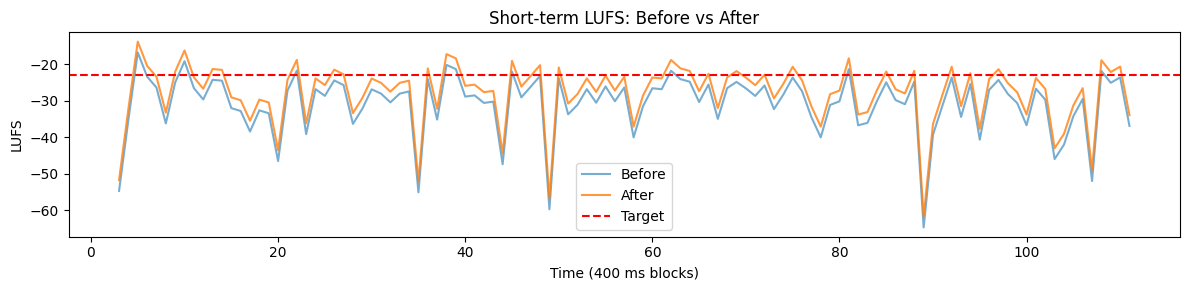

In [18]:
# Plotting Short-term LUFS Before and After LUFS Normalization
plt.figure(figsize=(12, 3))
plt.plot(lufs_before, alpha=0.6, label="Before")
plt.plot(lufs_after,  alpha=0.8, label="After")
plt.axhline(-23, color="red", linestyle="--", label="Target")
plt.title("Short-term LUFS: Before vs After")
plt.xlabel("Time (400 ms blocks)")
plt.ylabel("LUFS")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Observation 4: LUFS Normalization shifts the LUFS slightly
# Conclusion 4: LUFS Normalization might be tested as pre-processing for getting better on metric

In [21]:
# Final Settings:
# a) Predict log of Target MOS Scores and scale them back afterwards
# b) Try LUFS Normalization in the end for final metric jump